# Notebook 02h : Transformer Hiérarchique (Classification 3 zones + Régression conditionnelle)

## Modifications par rapport au notebook 02g

1. **Classification explicite 3 zones** : un head de classification prédit la zone (gauche / haut / droite) à partir de la distance curviligne `d`. Les coins du U sont inclus dans le couloir haut.

2. **Régression conditionnelle** : trois heads de régression spécialisés (un par zone) prédisent (x, y) + incertitude. La prédiction finale est un **mélange pondéré** par les probabilités de classification (softmax).

3. **Loss hiérarchique** : chaque head de régression n'est entraîné que sur les exemples de sa zone (routage par les labels ground truth).

4. **Spike dropout (15%) + Gaussian noise (std=0.5)** : data augmentation identique au notebook 02d.

**Géométrie du U** (coordonnées normalisées [0, 1]) :
- Bras gauche : x ∈ [0, 0.3], y ∈ [0, 1]
- Bras droit : x ∈ [0.7, 1.0], y ∈ [0, 1]
- Couloir haut : x ∈ [0, 1], y ∈ [0.7, 1.0]
- Largeur du couloir : 0.3

**Squelette central** : 3 segments formant un U :
1. (0.15, 0) → (0.15, 0.85) — bras gauche, longueur 0.85
2. (0.15, 0.85) → (0.85, 0.85) — couloir haut, longueur 0.70
3. (0.85, 0.85) → (0.85, 0) — bras droit, longueur 0.85

**Classification 3 zones** (basée sur d curviligne, total = 2.40) :
- Gauche (classe 0) : d < 0.354 (bras gauche pur)
- Haut (classe 1) : 0.354 ≤ d < 0.646 (couloir haut + coins)
- Droite (classe 2) : d ≥ 0.646 (bras droit pur)

**Loss combinée** : `L = L_cls (CrossEntropy) + Σ L_pos_zone (Gaussian NLL, masqué) + λ_d * L_curvilinear (MSE) + λ_feas * L_feasibility`

## 1. Imports et configuration

In [5]:
import pandas as pd
import numpy as np
import json
import os
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

# Reproductibilité
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')
print(f'Device: {DEVICE}')

Device: cuda


In [6]:
# --- Chargement des données ---
LOCAL_DIR = os.path.join(os.path.abspath('..'), 'data')

PARQUET_NAME = "M1199_PAG_stride4_win108_test.parquet"
JSON_NAME = "M1199_PAG.json"

PARQUET_FILE = os.path.join(LOCAL_DIR, PARQUET_NAME)
JSON_FILE = os.path.join(LOCAL_DIR, JSON_NAME)

if not os.path.exists(PARQUET_FILE):
    raise FileNotFoundError(
        f"Données introuvables dans {LOCAL_DIR}/\n"
        f"Lancez d'abord: python download_data.py"
    )

print(f"Chargement depuis {LOCAL_DIR}/")
df = pd.read_parquet(PARQUET_FILE)
with open(JSON_FILE, "r") as f:
    params = json.load(f)

print(f"Shape: {df.shape}")

nGroups = params['nGroups']
nChannelsPerGroup = [params[f'group{g}']['nChannels'] for g in range(nGroups)]
print(f"nGroups={nGroups}, nChannelsPerGroup={nChannelsPerGroup}")

Chargement depuis /home/onyxia/work/hacktion-potential/data/
Shape: (62257, 18)
nGroups=4, nChannelsPerGroup=[6, 4, 6, 4]


## 2. Chargement et filtrage

In [7]:
speed_masks = np.array([x[0] for x in df['speedMask']])
df_moving = df[speed_masks].reset_index(drop=True)
print(f'Exemples en mouvement : {len(df_moving)}')

Exemples en mouvement : 22974


## 3. Géométrie du U-maze, distance curviligne et labels de zone

**3 zones** basées sur les segments du squelette :
- Gauche (classe 0) : d < 0.354 — bras gauche pur (hors coin)
- Haut (classe 1) : 0.354 ≤ d < 0.646 — couloir haut + coins
- Droite (classe 2) : d ≥ 0.646 — bras droit pur (hors coin)

In [8]:
# --- Définition du squelette du U ---
SKELETON_SEGMENTS = np.array([
    [0.15, 0.0, 0.15, 0.85],   # Segment 1 : bras gauche (bas → haut)
    [0.15, 0.85, 0.85, 0.85],  # Segment 2 : couloir haut (gauche → droite)
    [0.85, 0.85, 0.85, 0.0],   # Segment 3 : bras droit (haut → bas)
])

CORRIDOR_HALF_WIDTH = 0.15

SEGMENT_LENGTHS = np.array([
    np.sqrt((s[2]-s[0])**2 + (s[3]-s[1])**2) for s in SKELETON_SEGMENTS
])
TOTAL_LENGTH = SEGMENT_LENGTHS.sum()  # 2.40
CUMULATIVE_LENGTHS = np.concatenate([[0], np.cumsum(SEGMENT_LENGTHS)])

# Seuils de zone (frontières naturelles entre segments)
D_LEFT_END = CUMULATIVE_LENGTHS[1] / TOTAL_LENGTH    # 0.85 / 2.40 ≈ 0.354
D_RIGHT_START = CUMULATIVE_LENGTHS[2] / TOTAL_LENGTH  # 1.55 / 2.40 ≈ 0.646

N_ZONES = 3
ZONE_NAMES = ['Gauche', 'Haut', 'Droite']

print(f'Longueurs des segments : {SEGMENT_LENGTHS}')
print(f'Longueur totale du U : {TOTAL_LENGTH:.2f}')
print(f'\nSeuils de zone :')
print(f'  Gauche (classe 0) : d < {D_LEFT_END:.4f}')
print(f'  Haut   (classe 1) : {D_LEFT_END:.4f} <= d < {D_RIGHT_START:.4f}')
print(f'  Droite (classe 2) : d >= {D_RIGHT_START:.4f}')


def project_point_on_segment(px, py, x1, y1, x2, y2):
    """Projette un point (px, py) sur le segment [(x1,y1), (x2,y2)]."""
    dx, dy = x2 - x1, y2 - y1
    seg_len_sq = dx**2 + dy**2
    if seg_len_sq < 1e-12:
        return 0.0, np.sqrt((px - x1)**2 + (py - y1)**2), x1, y1
    t = ((px - x1) * dx + (py - y1) * dy) / seg_len_sq
    t = np.clip(t, 0.0, 1.0)
    proj_x = x1 + t * dx
    proj_y = y1 + t * dy
    dist = np.sqrt((px - proj_x)**2 + (py - proj_y)**2)
    return t, dist, proj_x, proj_y


def compute_curvilinear_distance(x, y):
    """Calcule la distance curviligne normalisée d ∈ [0, 1] le long du U."""
    best_dist = np.inf
    best_d = 0.0
    for i, (x1, y1, x2, y2) in enumerate(SKELETON_SEGMENTS):
        t, dist, _, _ = project_point_on_segment(x, y, x1, y1, x2, y2)
        if dist < best_dist:
            best_dist = dist
            best_d = (CUMULATIVE_LENGTHS[i] + t * SEGMENT_LENGTHS[i]) / TOTAL_LENGTH
    return best_d


def compute_distance_to_skeleton(x, y):
    """Distance minimale du point (x, y) au squelette du U."""
    best_dist = np.inf
    for x1, y1, x2, y2 in SKELETON_SEGMENTS:
        _, dist, _, _ = project_point_on_segment(x, y, x1, y1, x2, y2)
        best_dist = min(best_dist, dist)
    return best_dist


def d_to_zone(d):
    """Convertit une distance curviligne d en label de zone (0, 1, 2)."""
    if d < D_LEFT_END:
        return 0  # Gauche
    elif d < D_RIGHT_START:
        return 1  # Haut
    else:
        return 2  # Droite


# --- Calcul de d et zone_labels pour tous les exemples ---
positions = np.array([[x[0], x[1]] for x in df_moving['pos']], dtype=np.float32)
curvilinear_d = np.array([
    compute_curvilinear_distance(x, y) for x, y in positions
], dtype=np.float32)

zone_labels = np.array([d_to_zone(d) for d in curvilinear_d], dtype=np.int64)

print(f'\nd curviligne : min={curvilinear_d.min():.4f}, max={curvilinear_d.max():.4f}, mean={curvilinear_d.mean():.4f}')
print(f'\nDistribution des zones :')
for z in range(N_ZONES):
    count = (zone_labels == z).sum()
    print(f'  {ZONE_NAMES[z]:8s} (classe {z}) : {count} ({count / len(zone_labels):.1%})')

dist_to_skel = np.array([compute_distance_to_skeleton(x, y) for x, y in positions])
print(f'\nDistance au squelette : mean={dist_to_skel.mean():.4f}, max={dist_to_skel.max():.4f}')
print(f'  % dans le couloir (dist < {CORRIDOR_HALF_WIDTH}) : {(dist_to_skel < CORRIDOR_HALF_WIDTH).mean():.1%}')

Longueurs des segments : [0.85 0.7  0.85]
Longueur totale du U : 2.40

Seuils de zone :
  Gauche (classe 0) : d < 0.3542
  Haut   (classe 1) : 0.3542 <= d < 0.6458
  Droite (classe 2) : d >= 0.6458

d curviligne : min=0.0000, max=1.0000, mean=0.4727

Distribution des zones :
  Gauche   (classe 0) : 8655 (37.7%)
  Haut     (classe 1) : 7851 (34.2%)
  Droite   (classe 2) : 6468 (28.2%)

Distance au squelette : mean=0.0725, max=0.1943
  % dans le couloir (dist < 0.15) : 95.3%


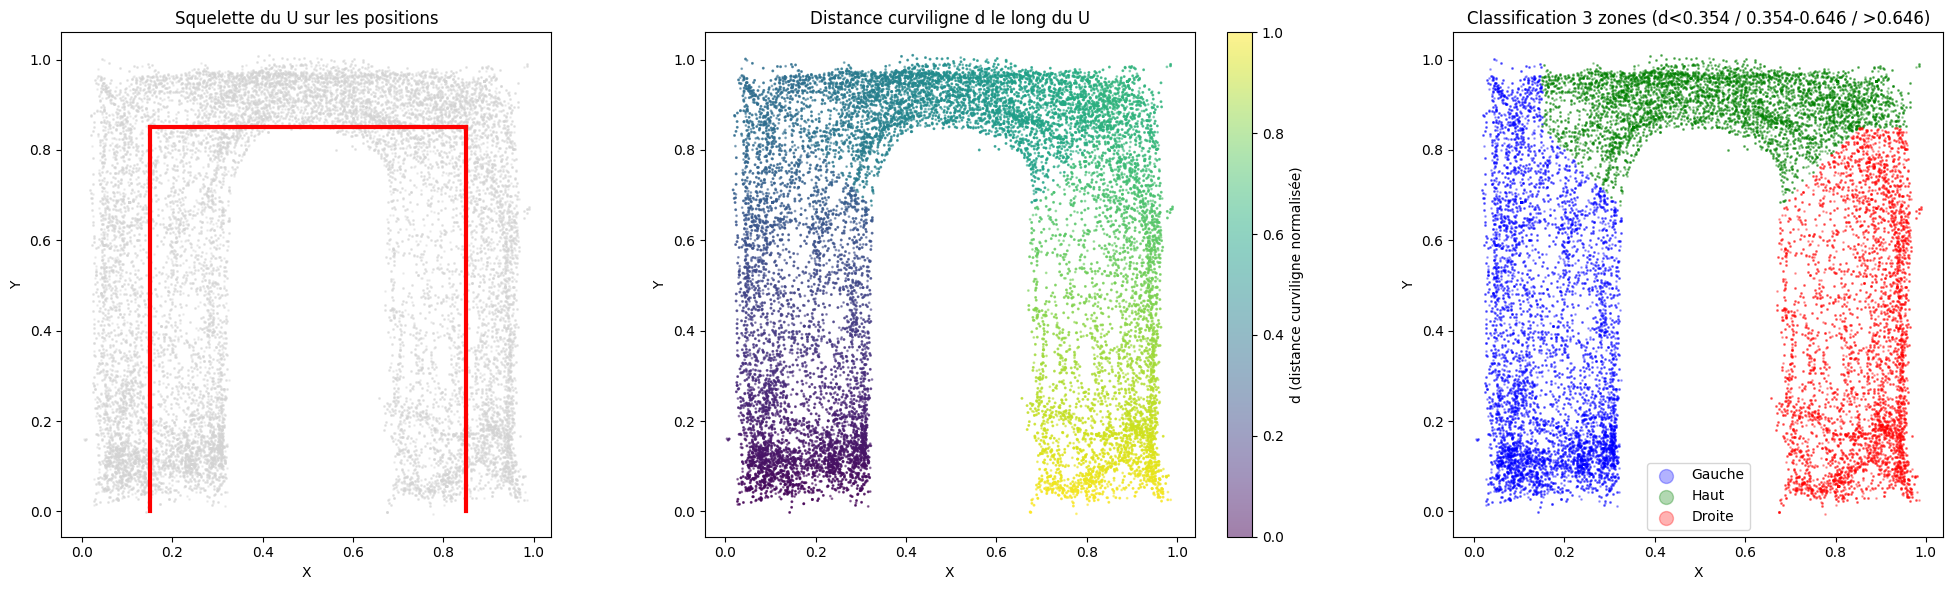

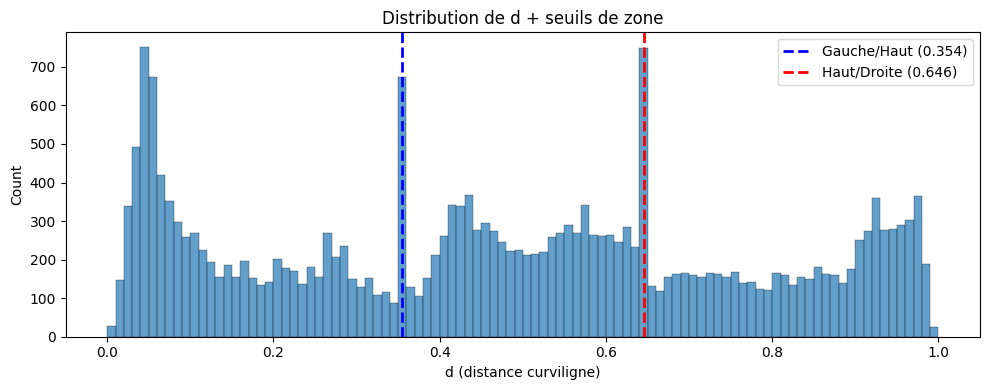

In [9]:
# --- Visualisation : d + classification 3 zones ---
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# 1. Squelette
axes[0].scatter(positions[:, 0], positions[:, 1], c='lightgray', s=1, alpha=0.3)
for x1, y1, x2, y2 in SKELETON_SEGMENTS:
    axes[0].plot([x1, x2], [y1, y2], 'r-', linewidth=3)
axes[0].set_xlabel('X'); axes[0].set_ylabel('Y')
axes[0].set_title('Squelette du U sur les positions')
axes[0].set_aspect('equal')

# 2. d coloré
sc = axes[1].scatter(positions[:, 0], positions[:, 1], c=curvilinear_d, s=1, alpha=0.5, cmap='viridis')
plt.colorbar(sc, ax=axes[1], label='d (distance curviligne normalisée)')
axes[1].set_xlabel('X'); axes[1].set_ylabel('Y')
axes[1].set_title('Distance curviligne d le long du U')
axes[1].set_aspect('equal')

# 3. Classification 3 zones
zone_colors = ['blue', 'green', 'red']
for z in range(N_ZONES):
    mask_z = zone_labels == z
    axes[2].scatter(positions[mask_z, 0], positions[mask_z, 1], c=zone_colors[z], s=1, alpha=0.3, label=f'{ZONE_NAMES[z]}')
axes[2].set_xlabel('X'); axes[2].set_ylabel('Y')
axes[2].set_title(f'Classification 3 zones (d<{D_LEFT_END:.3f} / {D_LEFT_END:.3f}-{D_RIGHT_START:.3f} / >{D_RIGHT_START:.3f})')
axes[2].legend(markerscale=10)
axes[2].set_aspect('equal')

plt.tight_layout()
plt.show()

# Histogramme de d avec seuils
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(curvilinear_d, bins=100, alpha=0.7, edgecolor='black', linewidth=0.3)
ax.axvline(x=D_LEFT_END, color='blue', linestyle='--', linewidth=2, label=f'Gauche/Haut ({D_LEFT_END:.3f})')
ax.axvline(x=D_RIGHT_START, color='red', linestyle='--', linewidth=2, label=f'Haut/Droite ({D_RIGHT_START:.3f})')
ax.set_xlabel('d (distance curviligne)'); ax.set_ylabel('Count')
ax.set_title('Distribution de d + seuils de zone')
ax.legend()
plt.tight_layout()
plt.show()

## 4. Preprocessing : reconstruction de la séquence chronologique

In [10]:
def reconstruct_sequence(row, nGroups, nChannelsPerGroup, max_seq_len=128):
    """Reconstruit la séquence chronologique de spikes."""
    groups = row['groups']
    length = min(len(groups), max_seq_len)
    waveforms = {}
    for g in range(nGroups):
        nCh = nChannelsPerGroup[g]
        raw = row[f'group{g}']
        waveforms[g] = raw.reshape(-1, nCh, 32)
    seq_waveforms = []
    seq_shank_ids = []
    for t in range(length):
        g = int(groups[t])
        idx = int(row[f'indices{g}'][t])
        if idx > 0 and idx <= waveforms[g].shape[0]:
            seq_waveforms.append((waveforms[g][idx - 1], g))
            seq_shank_ids.append(g)
    return seq_waveforms, seq_shank_ids

wf, sids = reconstruct_sequence(df_moving.iloc[0], nGroups, nChannelsPerGroup)
print(f'Premier exemple : {len(wf)} spikes, shanks={set(sids)}')

Premier exemple : 78 spikes, shanks={0, 1, 2, 3}


## 5. Dataset PyTorch (avec zone_label)

In [11]:
MAX_SEQ_LEN = 128
MAX_CHANNELS = max(nChannelsPerGroup)  # 6

class SpikeSequenceDataset(Dataset):
    def __init__(self, dataframe, nGroups, nChannelsPerGroup, curvilinear_d, zone_labels, max_seq_len=MAX_SEQ_LEN):
        self.df = dataframe
        self.nGroups = nGroups
        self.nChannelsPerGroup = nChannelsPerGroup
        self.max_seq_len = max_seq_len
        self.targets = np.array([[x[0], x[1]] for x in dataframe['pos']], dtype=np.float32)
        self.curvilinear_d = curvilinear_d.astype(np.float32)
        self.zone_labels = zone_labels.astype(np.int64)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        seq, shank_ids = reconstruct_sequence(row, self.nGroups, self.nChannelsPerGroup, self.max_seq_len)
        seq_len = len(seq)
        if seq_len == 0:
            seq_len = 1
            waveforms = np.zeros((1, MAX_CHANNELS, 32), dtype=np.float32)
            shank_ids_arr = np.array([0], dtype=np.int64)
        else:
            waveforms = np.zeros((seq_len, MAX_CHANNELS, 32), dtype=np.float32)
            shank_ids_arr = np.array(shank_ids, dtype=np.int64)
            for t, (wf, g) in enumerate(seq):
                nCh = wf.shape[0]
                waveforms[t, :nCh, :] = wf
        return {
            'waveforms': torch.from_numpy(waveforms),
            'shank_ids': torch.from_numpy(shank_ids_arr),
            'seq_len': seq_len,
            'target': torch.from_numpy(self.targets[idx]),
            'd': torch.tensor(self.curvilinear_d[idx], dtype=torch.float32),
            'zone': torch.tensor(self.zone_labels[idx], dtype=torch.long)
        }


def collate_fn(batch):
    max_len = max(item['seq_len'] for item in batch)
    batch_size = len(batch)
    waveforms = torch.zeros(batch_size, max_len, MAX_CHANNELS, 32)
    shank_ids = torch.zeros(batch_size, max_len, dtype=torch.long)
    mask = torch.ones(batch_size, max_len, dtype=torch.bool)
    targets = torch.stack([item['target'] for item in batch])
    d_targets = torch.stack([item['d'] for item in batch])
    zone_targets = torch.stack([item['zone'] for item in batch])
    for i, item in enumerate(batch):
        sl = item['seq_len']
        waveforms[i, :sl] = item['waveforms']
        shank_ids[i, :sl] = item['shank_ids']
        mask[i, :sl] = False
    return {
        'waveforms': waveforms, 'shank_ids': shank_ids, 'mask': mask,
        'targets': targets, 'd_targets': d_targets, 'zone_targets': zone_targets
    }

print('Dataset et collate_fn définis (avec zone_label 3 classes).')

Dataset et collate_fn définis (avec zone_label 3 classes).


## 6. Feasibility Loss

In [12]:
class FeasibilityLoss(nn.Module):
    """Pénalise les prédictions (x, y) qui tombent hors du couloir du U."""
    def __init__(self, skeleton_segments, corridor_half_width):
        super().__init__()
        self.register_buffer('segments', torch.tensor(skeleton_segments, dtype=torch.float32))
        self.corridor_half_width = corridor_half_width
    
    def forward(self, xy_pred):
        px, py = xy_pred[:, 0], xy_pred[:, 1]
        distances = []
        for i in range(self.segments.shape[0]):
            x1, y1, x2, y2 = self.segments[i]
            dx, dy = x2 - x1, y2 - y1
            seg_len_sq = dx**2 + dy**2
            t = ((px - x1) * dx + (py - y1) * dy) / (seg_len_sq + 1e-8)
            t = t.clamp(0.0, 1.0)
            proj_x, proj_y = x1 + t * dx, y1 + t * dy
            dist = torch.sqrt((px - proj_x)**2 + (py - proj_y)**2 + 1e-8)
            distances.append(dist)
        distances = torch.stack(distances, dim=1)
        min_dist = distances.min(dim=1).values
        return torch.relu(min_dist - self.corridor_half_width).pow(2).mean()

feas_loss = FeasibilityLoss(SKELETON_SEGMENTS, CORRIDOR_HALF_WIDTH)
print(f'Pénalité (dans le couloir) : {feas_loss(torch.tensor([[0.15, 0.5], [0.85, 0.3]])).item():.6f}')
print(f'Pénalité (hors couloir)    : {feas_loss(torch.tensor([[0.5, 0.3], [0.5, 0.5]])).item():.6f}')

Pénalité (dans le couloir) : 0.000000
Pénalité (hors couloir)    : 0.040000


## 7. Architecture du modèle hiérarchique (3 zones)

**Backbone partagé** : identique à 02g.

**Heads spécialisés** :
- `cls_head` : classification 3 classes → logits (3,) → softmax
- `mu_heads[0..2]` + `log_sigma_heads[0..2]` : régression par zone
- `d_head` : prédiction de d (tâche auxiliaire)

**Combinaison à l'inférence** :
```
p = softmax(cls_logits)  # (batch, 3)
mu = Σ p_z * mu_z
sigma² = Σ p_z * (sigma_z² + mu_z²) - mu²
```

In [13]:
class SpikeEncoder(nn.Module):
    def __init__(self, n_channels, embed_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(n_channels, 32, kernel_size=5, padding=2), nn.ReLU(),
            nn.Conv1d(32, embed_dim, kernel_size=3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
    def forward(self, x):
        return self.conv(x).squeeze(-1)


class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=256):
        super().__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


class SpikeTransformerHierarchical(nn.Module):
    """Transformer hiérarchique : classification 3 zones + régression conditionnelle."""
    
    def __init__(self, nGroups, nChannelsPerGroup, n_zones=3, embed_dim=64, nhead=4,
                 num_layers=2, dropout=0.2, spike_dropout=0.15, noise_std=0.5,
                 max_channels=MAX_CHANNELS):
        super().__init__()
        self.nGroups = nGroups
        self.embed_dim = embed_dim
        self.n_zones = n_zones
        self.max_channels = max_channels
        self.spike_dropout = spike_dropout
        self.noise_std = noise_std
        
        self.spike_encoders = nn.ModuleList([
            SpikeEncoder(max_channels, embed_dim) for _ in range(nGroups)
        ])
        self.shank_embedding = nn.Embedding(nGroups, embed_dim)
        self.pos_encoding = PositionalEncoding(embed_dim)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=nhead, dim_feedforward=embed_dim * 4,
            dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers, enable_nested_tensor=False
        )
        
        # Classification 3 zones
        self.cls_head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(embed_dim, n_zones)
        )
        
        # Régression par zone : mu + log_sigma
        self.mu_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(embed_dim, embed_dim), nn.ReLU(), nn.Dropout(dropout),
                nn.Linear(embed_dim, 2)
            ) for _ in range(n_zones)
        ])
        self.log_sigma_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(embed_dim, embed_dim), nn.ReLU(), nn.Dropout(dropout),
                nn.Linear(embed_dim, 2)
            ) for _ in range(n_zones)
        ])
        
        # Distance curviligne
        self.d_head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(embed_dim, 1), nn.Sigmoid()
        )
    
    def _apply_spike_dropout(self, mask):
        if not self.training or self.spike_dropout <= 0:
            return mask
        drop_mask = torch.rand_like(mask.float()) < self.spike_dropout
        active = ~mask
        new_drops = drop_mask & active
        remaining = active & ~new_drops
        all_dropped = remaining.sum(dim=1) == 0
        if all_dropped.any():
            new_drops[all_dropped] = False
        return mask | new_drops
    
    def _apply_waveform_noise(self, waveforms):
        if not self.training or self.noise_std <= 0:
            return waveforms
        return waveforms + torch.randn_like(waveforms) * self.noise_std
    
    def _encode(self, waveforms, shank_ids, mask):
        """Shared backbone : encode → transformer → pooling."""
        batch_size, seq_len = waveforms.shape[:2]
        mask = self._apply_spike_dropout(mask)
        waveforms = self._apply_waveform_noise(waveforms)
        
        embeddings = torch.zeros(batch_size, seq_len, self.embed_dim, device=waveforms.device)
        for g in range(self.nGroups):
            group_mask = (shank_ids == g) & (~mask)
            if group_mask.any():
                embeddings[group_mask] = self.spike_encoders[g](waveforms[group_mask])
        
        embeddings = embeddings + self.shank_embedding(shank_ids)
        embeddings = self.pos_encoding(embeddings)
        encoded = self.transformer(embeddings, src_key_padding_mask=mask)
        
        active_mask = (~mask).unsqueeze(-1).float()
        pooled = (encoded * active_mask).sum(dim=1) / (active_mask.sum(dim=1) + 1e-8)
        return pooled
    
    def forward(self, waveforms, shank_ids, mask):
        """
        Returns:
            cls_logits: (batch, 3)
            mus: list of 3 × (batch, 2)
            sigmas: list of 3 × (batch, 2)
            d_pred: (batch, 1)
        """
        pooled = self._encode(waveforms, shank_ids, mask)
        cls_logits = self.cls_head(pooled)
        mus = [head(pooled) for head in self.mu_heads]
        sigmas = [torch.exp(head(pooled)) for head in self.log_sigma_heads]
        d_pred = self.d_head(pooled)
        return cls_logits, mus, sigmas, d_pred
    
    def predict(self, waveforms, shank_ids, mask):
        """Prédiction combinée via mélange pondéré par softmax."""
        cls_logits, mus, sigmas, d_pred = self.forward(waveforms, shank_ids, mask)
        probs = torch.softmax(cls_logits, dim=1)  # (batch, 3)
        
        # Mélange pondéré
        mu_stack = torch.stack(mus, dim=1)       # (batch, 3, 2)
        sigma_stack = torch.stack(sigmas, dim=1)  # (batch, 3, 2)
        p = probs.unsqueeze(-1)                   # (batch, 3, 1)
        
        mu = (p * mu_stack).sum(dim=1)  # (batch, 2)
        
        # Variance totale
        var_combined = (p * (sigma_stack ** 2 + mu_stack ** 2)).sum(dim=1) - mu ** 2
        sigma = torch.sqrt(var_combined.clamp(min=1e-8))
        
        return mu, sigma, probs, d_pred


model = SpikeTransformerHierarchical(nGroups, nChannelsPerGroup)
n_params = sum(p.numel() for p in model.parameters())
print(f'Modèle créé : {n_params:,} paramètres')
print(f'Têtes : classification 3 zones + 3 régressions conditionnelles + d curviligne')

Modèle créé : 163,344 paramètres
Têtes : classification 3 zones + 3 régressions conditionnelles + d curviligne


## 8. Split et DataLoaders

In [14]:
from sklearn.model_selection import KFold

split_idx = int(len(df_moving) * 0.9)
df_train_full = df_moving.iloc[:split_idx].reset_index(drop=True)
df_test = df_moving.iloc[split_idx:].reset_index(drop=True)
d_train_full = curvilinear_d[:split_idx]
d_test = curvilinear_d[split_idx:]
zone_train_full = zone_labels[:split_idx]
zone_test = zone_labels[split_idx:]

print(f'Train : {len(df_train_full)} | Test : {len(df_test)}')
for z in range(N_ZONES):
    print(f'  {ZONE_NAMES[z]:8s} — train: {(zone_train_full == z).sum()}, test: {(zone_test == z).sum()}')

N_FOLDS = 2
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=41)
BATCH_SIZE = 64

test_dataset = SpikeSequenceDataset(df_test, nGroups, nChannelsPerGroup, d_test, zone_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)
print(f'Test: {len(test_dataset)} exemples, {len(test_loader)} batches')

Train : 20676 | Test : 2298
  Gauche   — train: 7804, test: 851
  Haut     — train: 6904, test: 947
  Droite   — train: 5968, test: 500
Test: 2298 exemples, 36 batches


## 9. Entraînement (5-Fold Cross-Validation)

**Loss combinée** :
```
L = L_cls (CrossEntropy 3 classes)
  + Σ_z L_pos_z (Gaussian NLL, masqué sur zone z)
  + λ_d * L_curvilinear (MSE)
  + λ_feas * L_feasibility
```

In [15]:
EMBED_DIM = 64
NHEAD = 4
NUM_LAYERS = 2
DROPOUT = 0.2
SPIKE_DROPOUT = 0.15
NOISE_STD = 0.5
LR = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 10
PATIENCE = 7
LAMBDA_D = 1.0
LAMBDA_FEAS = 10.0

print(f'Loss : CrossEntropy(cls) + GaussianNLL(par zone) + {LAMBDA_D}*MSE(d) + {LAMBDA_FEAS}*Feasibility')
print(f'Device : {DEVICE}')

Loss : CrossEntropy(cls) + GaussianNLL(par zone) + 1.0*MSE(d) + 10.0*Feasibility
Device : cuda


In [16]:
def train_epoch(model, loader, optimizer, scheduler, criterion_ce, criterion_nll, criterion_d, feas_loss, device):
    model.train()
    totals = {'loss': 0, 'cls': 0, 'pos': 0, 'd': 0, 'feas': 0, 'correct': 0, 'n': 0, 'batches': 0}
    
    for batch in loader:
        wf = batch['waveforms'].to(device)
        sid = batch['shank_ids'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['targets'].to(device)
        d_targets = batch['d_targets'].to(device)
        zone_targets = batch['zone_targets'].to(device)
        
        optimizer.zero_grad()
        cls_logits, mus, sigmas, d_pred = model(wf, sid, mask)
        
        # Classification (CrossEntropy)
        loss_cls = criterion_ce(cls_logits, zone_targets)
        
        # Régression par zone (masquée)
        loss_pos = torch.tensor(0.0, device=device)
        for z in range(N_ZONES):
            zmask = (zone_targets == z)
            if zmask.any():
                loss_pos = loss_pos + criterion_nll(
                    mus[z][zmask], targets[zmask], sigmas[z][zmask] ** 2
                )
        
        # Curviligne + Feasibility
        loss_d = criterion_d(d_pred.squeeze(-1), d_targets)
        
        probs = torch.softmax(cls_logits, dim=1).unsqueeze(-1)  # (batch, 3, 1)
        mu_stack = torch.stack(mus, dim=1)  # (batch, 3, 2)
        mu_combined = (probs * mu_stack).sum(dim=1)  # (batch, 2)
        loss_feas = feas_loss(mu_combined)
        
        loss = loss_cls + loss_pos + LAMBDA_D * loss_d + LAMBDA_FEAS * loss_feas
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        totals['loss'] += loss.item()
        totals['cls'] += loss_cls.item()
        totals['pos'] += loss_pos.item()
        totals['d'] += loss_d.item()
        totals['feas'] += loss_feas.item()
        with torch.no_grad():
            totals['correct'] += (cls_logits.argmax(dim=1) == zone_targets).sum().item()
            totals['n'] += len(zone_targets)
        totals['batches'] += 1
    
    nb = totals['batches']
    return {k: totals[k] / nb for k in ['loss', 'cls', 'pos', 'd', 'feas']}, totals['correct'] / totals['n']


@torch.no_grad()
def eval_epoch(model, loader, criterion_ce, criterion_nll, criterion_d, feas_loss, device):
    model.eval()
    totals = {'loss': 0, 'cls': 0, 'pos': 0, 'd': 0, 'feas': 0, 'correct': 0, 'n': 0, 'batches': 0}
    all_mu, all_sigma, all_probs, all_d, all_targets, all_d_targets, all_zone_targets = [], [], [], [], [], [], []
    
    for batch in loader:
        wf = batch['waveforms'].to(device)
        sid = batch['shank_ids'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['targets'].to(device)
        d_targets = batch['d_targets'].to(device)
        zone_targets = batch['zone_targets'].to(device)
        
        mu, sigma, probs, d_pred = model.predict(wf, sid, mask)
        cls_logits, mus, sigmas, _ = model(wf, sid, mask)
        
        loss_cls = criterion_ce(cls_logits, zone_targets)
        loss_pos = torch.tensor(0.0, device=device)
        for z in range(N_ZONES):
            zmask = (zone_targets == z)
            if zmask.any():
                loss_pos = loss_pos + criterion_nll(mus[z][zmask], targets[zmask], sigmas[z][zmask] ** 2)
        loss_d = criterion_d(d_pred.squeeze(-1), d_targets)
        loss_feas = feas_loss(mu)
        loss = loss_cls + loss_pos + LAMBDA_D * loss_d + LAMBDA_FEAS * loss_feas
        
        totals['loss'] += loss.item(); totals['cls'] += loss_cls.item()
        totals['pos'] += loss_pos.item(); totals['d'] += loss_d.item()
        totals['feas'] += loss_feas.item()
        totals['correct'] += (cls_logits.argmax(dim=1) == zone_targets).sum().item()
        totals['n'] += len(zone_targets); totals['batches'] += 1
        
        all_mu.append(mu.cpu().numpy()); all_sigma.append(sigma.cpu().numpy())
        all_probs.append(probs.cpu().numpy()); all_d.append(d_pred.cpu().numpy())
        all_targets.append(targets.cpu().numpy()); all_d_targets.append(d_targets.cpu().numpy())
        all_zone_targets.append(zone_targets.cpu().numpy())
    
    nb = totals['batches']
    losses = {k: totals[k] / nb for k in ['loss', 'cls', 'pos', 'd', 'feas']}
    acc = totals['correct'] / totals['n']
    arrays = [np.concatenate(a) for a in [all_mu, all_sigma, all_probs, all_d, all_targets, all_d_targets, all_zone_targets]]
    return losses, acc, arrays

In [17]:
fold_results = []
all_train_losses = {}
all_val_losses = {}

for fold, (train_idx, val_idx) in enumerate(kf.split(df_train_full)):
    print(f'\n{"="*60}')
    print(f'FOLD {fold+1}/{N_FOLDS}')
    print(f'{"="*60}')
    
    df_ft = df_train_full.iloc[train_idx].reset_index(drop=True)
    df_fv = df_train_full.iloc[val_idx].reset_index(drop=True)
    
    ds_t = SpikeSequenceDataset(df_ft, nGroups, nChannelsPerGroup, d_train_full[train_idx], zone_train_full[train_idx])
    ds_v = SpikeSequenceDataset(df_fv, nGroups, nChannelsPerGroup, d_train_full[val_idx], zone_train_full[val_idx])
    dl_t = DataLoader(ds_t, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=0)
    dl_v = DataLoader(ds_v, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)
    
    print(f'  Train: {len(ds_t)}, Val: {len(ds_v)}')
    
    model = SpikeTransformerHierarchical(
        nGroups, nChannelsPerGroup, n_zones=N_ZONES,
        embed_dim=EMBED_DIM, nhead=NHEAD, num_layers=NUM_LAYERS,
        dropout=DROPOUT, spike_dropout=SPIKE_DROPOUT, noise_std=NOISE_STD
    ).to(DEVICE)
    
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, epochs=EPOCHS, steps_per_epoch=len(dl_t))
    criterion_ce = nn.CrossEntropyLoss()
    criterion_nll = nn.GaussianNLLLoss()
    criterion_d = nn.MSELoss()
    feas_loss_fn = FeasibilityLoss(SKELETON_SEGMENTS, CORRIDOR_HALF_WIDTH).to(DEVICE)
    
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses, val_losses = [], []
    model_path = f'../outputs/best_transformer_02h_fold{fold+1}.pt'
    
    for epoch in range(EPOCHS):
        t_losses, t_acc = train_epoch(model, dl_t, optimizer, scheduler, criterion_ce, criterion_nll, criterion_d, feas_loss_fn, DEVICE)
        v_losses, v_acc, _ = eval_epoch(model, dl_v, criterion_ce, criterion_nll, criterion_d, feas_loss_fn, DEVICE)
        
        train_losses.append(t_losses['loss'])
        val_losses.append(v_losses['loss'])
        
        if epoch % 5 == 0 or epoch == EPOCHS - 1:
            print(f'  Epoch {epoch+1:02d}/{EPOCHS} | Train: {t_losses["loss"]:.4f} (cls={t_losses["cls"]:.4f} pos={t_losses["pos"]:.4f} d={t_losses["d"]:.5f} feas={t_losses["feas"]:.6f} acc={t_acc:.1%}) | Val: {v_losses["loss"]:.4f} (acc={v_acc:.1%})')
        
        if v_losses['loss'] < best_val_loss:
            best_val_loss = v_losses['loss']
            patience_counter = 0
            torch.save(model.state_dict(), model_path)
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f'  Early stopping a epoch {epoch+1}')
                break
    
    all_train_losses[fold] = train_losses
    all_val_losses[fold] = val_losses
    
    model.load_state_dict(torch.load(model_path, map_location=DEVICE, weights_only=True))
    _, val_acc, (val_mu, val_sigma, val_probs, val_d_pred, val_targets, val_d_targets, val_zone_targets) = eval_epoch(
        model, dl_v, criterion_ce, criterion_nll, criterion_d, feas_loss_fn, DEVICE
    )
    val_eucl = np.sqrt(((val_targets - val_mu) ** 2).sum(axis=1))
    val_d_mae = np.abs(val_d_targets - val_d_pred.squeeze()).mean()
    
    val_dist_to_skel = np.array([compute_distance_to_skeleton(val_mu[i, 0], val_mu[i, 1]) for i in range(len(val_mu))])
    pct_outside = (val_dist_to_skel > CORRIDOR_HALF_WIDTH).mean()
    
    fold_results.append({
        'fold': fold + 1, 'best_val_loss': best_val_loss,
        'val_eucl_mean': val_eucl.mean(),
        'val_r2_x': r2_score(val_targets[:, 0], val_mu[:, 0]),
        'val_r2_y': r2_score(val_targets[:, 1], val_mu[:, 1]),
        'val_d_mae': val_d_mae, 'val_cls_acc': val_acc, 'val_pct_outside': pct_outside,
    })
    print(f'  => Eucl={val_eucl.mean():.4f} | R2: X={fold_results[-1]["val_r2_x"]:.4f} Y={fold_results[-1]["val_r2_y"]:.4f} | cls_acc={val_acc:.1%} | hors={pct_outside:.1%}')

print(f'\n{"="*60}')
print(f'RESUME ({N_FOLDS} folds)')
print(f'{"="*60}')
for r in fold_results:
    print(f'  Fold {r["fold"]}: Eucl={r["val_eucl_mean"]:.4f} | R2_X={r["val_r2_x"]:.4f} R2_Y={r["val_r2_y"]:.4f} | d_MAE={r["val_d_mae"]:.4f} | cls={r["val_cls_acc"]:.1%} | hors={r["val_pct_outside"]:.1%}')
print(f'\n  Moyenne : Eucl={np.mean([r["val_eucl_mean"] for r in fold_results]):.4f} | cls={np.mean([r["val_cls_acc"] for r in fold_results]):.1%} | hors={np.mean([r["val_pct_outside"] for r in fold_results]):.1%}')


FOLD 1/2
  Train: 10338, Val: 10338
  Epoch 01/10 | Train: -0.4381 (cls=1.1041 pos=-1.6682 d=0.08846 feas=0.003758 acc=36.4%) | Val: -1.1491 (acc=33.3%)
  Epoch 06/10 | Train: -2.9506 (cls=1.0558 pos=-4.1582 d=0.08682 feas=0.006501 acc=45.1%) | Val: -1.5850 (acc=49.8%)
  Epoch 10/10 | Train: -3.3858 (cls=0.9421 pos=-4.4595 d=0.08373 feas=0.004783 acc=52.8%) | Val: -1.7693 (acc=52.9%)
  => Eucl=0.3584 | R2: X=0.0380 Y=0.4362 | cls_acc=52.9% | hors=63.1%

FOLD 2/2
  Train: 10338, Val: 10338
  Epoch 01/10 | Train: -0.2301 (cls=1.1097 pos=-1.4704 d=0.09240 feas=0.003822 acc=36.1%) | Val: -1.0646 (acc=37.7%)
  Epoch 06/10 | Train: -2.9397 (cls=1.0186 pos=-4.0972 d=0.08614 feas=0.005278 acc=49.2%) | Val: -1.5903 (acc=52.4%)
  Epoch 10/10 | Train: -3.3883 (cls=0.9026 pos=-4.4135 d=0.07788 feas=0.004473 acc=54.7%) | Val: -1.8633 (acc=54.7%)
  => Eucl=0.3418 | R2: X=0.0809 Y=0.4703 | cls_acc=54.7% | hors=53.0%

RESUME (2 folds)
  Fold 1: Eucl=0.3584 | R2_X=0.0380 R2_Y=0.4362 | d_MAE=0.2419 | c

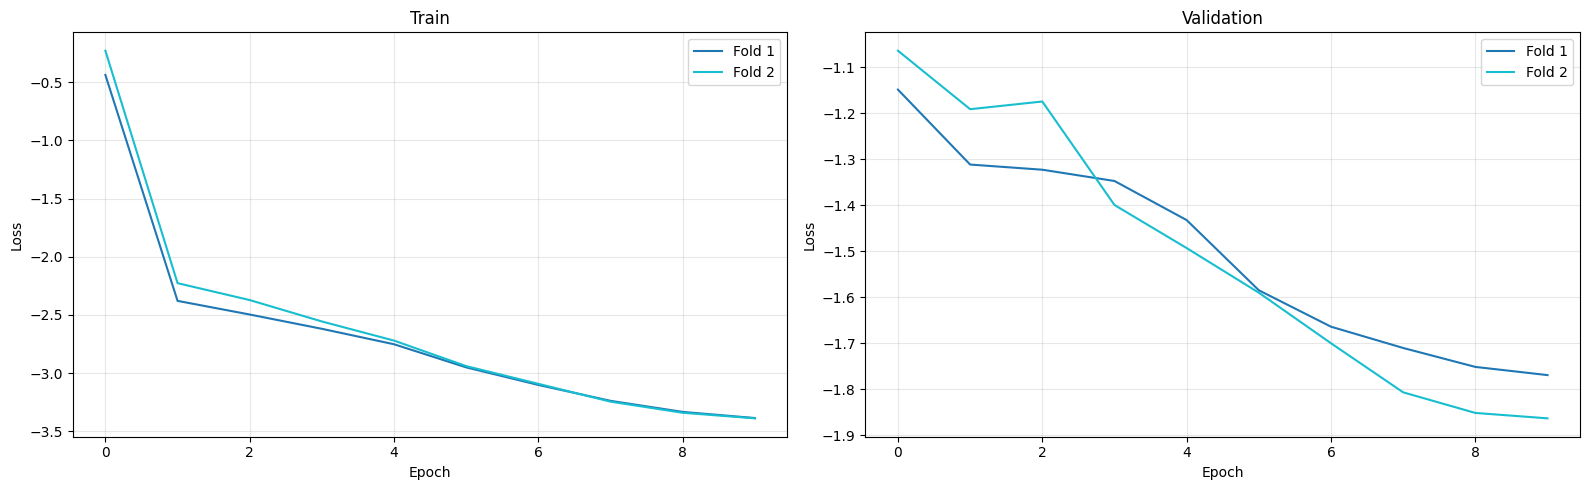

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
colors = plt.cm.tab10(np.linspace(0, 1, N_FOLDS))
for fold in range(N_FOLDS):
    axes[0].plot(all_train_losses[fold], color=colors[fold], linewidth=1.5, label=f'Fold {fold+1}')
    axes[1].plot(all_val_losses[fold], color=colors[fold], linewidth=1.5, label=f'Fold {fold+1}')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss'); axes[0].set_title('Train'); axes[0].legend(); axes[0].grid(True, alpha=0.3)
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Loss'); axes[1].set_title('Validation'); axes[1].legend(); axes[1].grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

## 10. Évaluation finale sur le test set

In [19]:
criterion_ce = nn.CrossEntropyLoss()
criterion_nll = nn.GaussianNLLLoss()
criterion_d = nn.MSELoss()
feas_loss_fn = FeasibilityLoss(SKELETON_SEGMENTS, CORRIDOR_HALF_WIDTH).to(DEVICE)

all_fold_mu, all_fold_sigma, all_fold_probs, all_fold_d = [], [], [], []

for fold in range(N_FOLDS):
    model = SpikeTransformerHierarchical(
        nGroups, nChannelsPerGroup, n_zones=N_ZONES,
        embed_dim=EMBED_DIM, nhead=NHEAD, num_layers=NUM_LAYERS,
        dropout=DROPOUT, spike_dropout=SPIKE_DROPOUT, noise_std=NOISE_STD
    ).to(DEVICE)
    model.load_state_dict(torch.load(f'../outputs/best_transformer_02h_fold{fold+1}.pt', map_location=DEVICE, weights_only=True))
    
    _, fold_acc, (fold_mu, fold_sigma, fold_probs, fold_d, y_test, d_test_targets, zone_test_targets) = eval_epoch(
        model, test_loader, criterion_ce, criterion_nll, criterion_d, feas_loss_fn, DEVICE
    )
    all_fold_mu.append(fold_mu); all_fold_sigma.append(fold_sigma)
    all_fold_probs.append(fold_probs); all_fold_d.append(fold_d)
    fold_eucl = np.sqrt(((y_test - fold_mu) ** 2).sum(axis=1))
    print(f'Fold {fold+1}: Eucl={fold_eucl.mean():.4f}, cls_acc={fold_acc:.1%}')

# Ensemble
all_fold_mu = np.stack(all_fold_mu)
all_fold_sigma = np.stack(all_fold_sigma)
all_fold_probs = np.stack(all_fold_probs)
all_fold_d = np.stack(all_fold_d)

y_pred = all_fold_mu.mean(axis=0)
d_pred_ensemble = all_fold_d.mean(axis=0).squeeze()
probs_ensemble = all_fold_probs.mean(axis=0)  # (n_test, 3)
zone_pred = probs_ensemble.argmax(axis=1)

mean_var = (all_fold_sigma ** 2).mean(axis=0)
var_mu = all_fold_mu.var(axis=0)
y_sigma = np.sqrt(mean_var + var_mu)

# Métriques
r2_x = r2_score(y_test[:, 0], y_pred[:, 0])
r2_y = r2_score(y_test[:, 1], y_pred[:, 1])
eucl_errors = np.sqrt(((y_test - y_pred) ** 2).sum(axis=1))
d_mae = np.abs(d_test_targets - d_pred_ensemble).mean()
d_r2 = r2_score(d_test_targets, d_pred_ensemble)
cls_accuracy = (zone_pred == zone_test_targets).mean()

test_dist_to_skel = np.array([compute_distance_to_skeleton(y_pred[i, 0], y_pred[i, 1]) for i in range(len(y_pred))])
pct_outside = (test_dist_to_skel > CORRIDOR_HALF_WIDTH).mean()

# Confusion par zone
zone_confusion = zone_pred != zone_test_targets
zone_confusion_rate = zone_confusion.mean()

print(f'\n{"="*60}')
print(f'Transformer 02h : Hiérarchique 3 zones — Ensemble ({N_FOLDS} folds)')
print(f'{"="*60}')
print(f'  R²   : X={r2_x:.4f}, Y={r2_y:.4f}')
print(f'  Eucl : mean={eucl_errors.mean():.4f}, median={np.median(eucl_errors):.4f}, p90={np.percentile(eucl_errors, 90):.4f}')
print(f'\n  d curviligne : MAE={d_mae:.4f}, R²={d_r2:.4f}')
print(f'  Classification zone : accuracy={cls_accuracy:.1%}')
print(f'  Hors labyrinthe : {pct_outside:.1%}')
print(f'  Confusion de zone : {zone_confusion_rate:.1%}')

print(f'\n  Erreur par zone :')
for z in range(N_ZONES):
    zmask = zone_test_targets == z
    if zmask.any():
        z_acc = (zone_pred[zmask] == z).mean()
        print(f'    {ZONE_NAMES[z]:8s} : Eucl={eucl_errors[zmask].mean():.4f} | cls_acc={z_acc:.1%} ({zmask.sum()} pts)')

print(f'\n  Sigma moyen : X={y_sigma[:, 0].mean():.4f}, Y={y_sigma[:, 1].mean():.4f}')

Fold 1: Eucl=0.3194, cls_acc=61.2%
Fold 2: Eucl=0.3024, cls_acc=62.6%

Transformer 02h : Hiérarchique 3 zones — Ensemble (2 folds)
  R²   : X=0.1398, Y=0.4909
  Eucl : mean=0.3069, median=0.2767, p90=0.5489

  d curviligne : MAE=0.2034, R²=0.1507
  Classification zone : accuracy=62.7%
  Hors labyrinthe : 58.1%
  Confusion de zone : 37.3%

  Erreur par zone :
    Gauche   : Eucl=0.2911 | cls_acc=80.6% (851 pts)
    Haut     : Eucl=0.2339 | cls_acc=79.4% (947 pts)
    Droite   : Eucl=0.4720 | cls_acc=0.4% (500 pts)

  Sigma moyen : X=0.2922, Y=0.2464


## 11. Visualisations

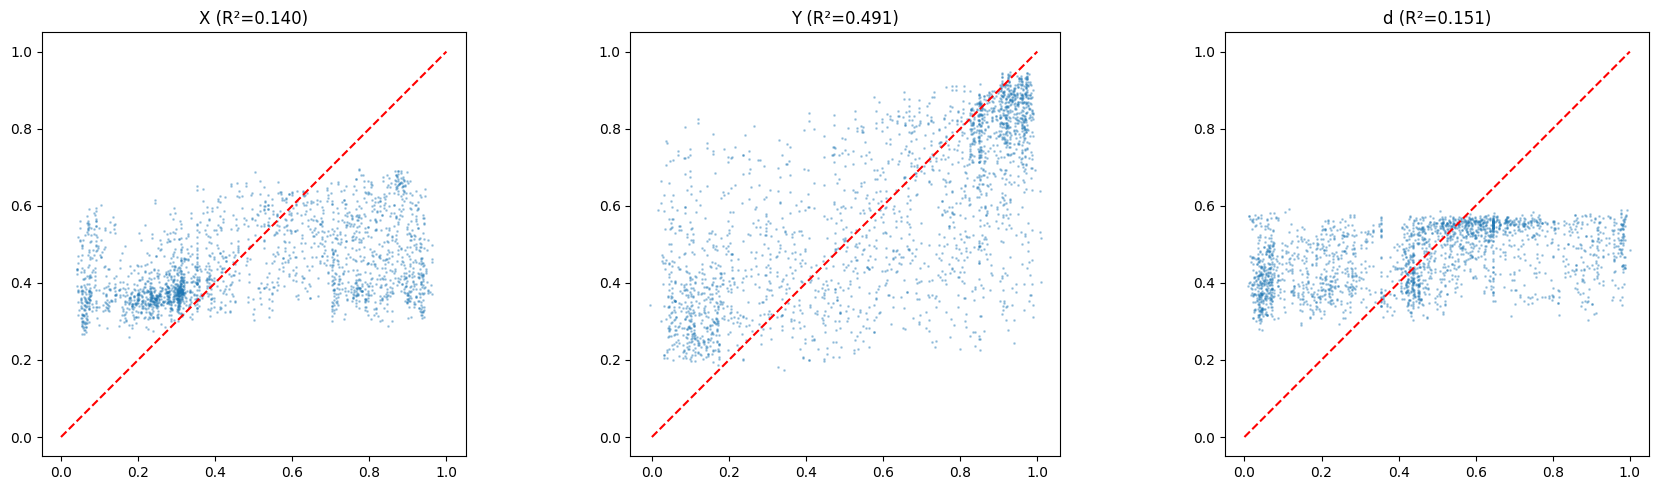

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].scatter(y_test[:, 0], y_pred[:, 0], s=1, alpha=0.3)
axes[0].plot([0, 1], [0, 1], 'r--'); axes[0].set_title(f'X (R²={r2_x:.3f})'); axes[0].set_aspect('equal')
axes[1].scatter(y_test[:, 1], y_pred[:, 1], s=1, alpha=0.3)
axes[1].plot([0, 1], [0, 1], 'r--'); axes[1].set_title(f'Y (R²={r2_y:.3f})'); axes[1].set_aspect('equal')
axes[2].scatter(d_test_targets, d_pred_ensemble, s=1, alpha=0.3)
axes[2].plot([0, 1], [0, 1], 'r--'); axes[2].set_title(f'd (R²={d_r2:.3f})'); axes[2].set_aspect('equal')
plt.tight_layout(); plt.show()

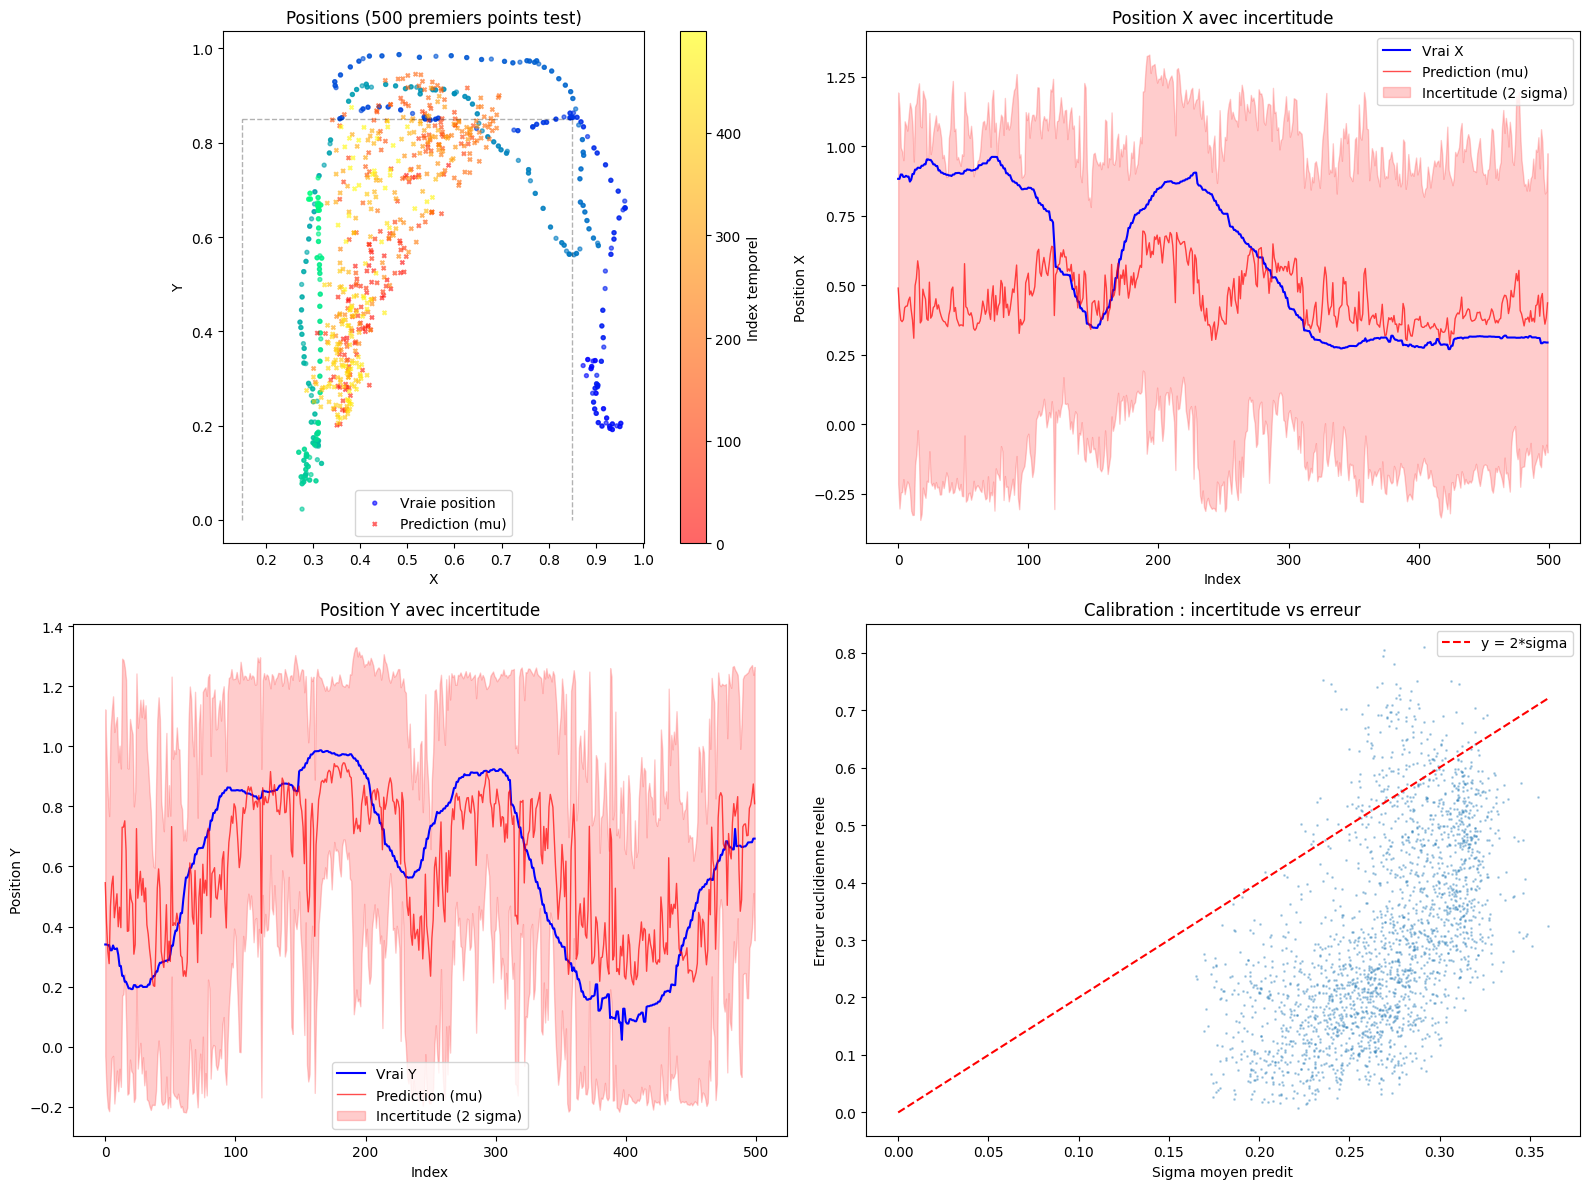

Calibration de l'incertitude :
  Erreur < 1*sigma : 48.1% (attendu ~39%)
  Erreur < 2*sigma : 92.6% (attendu ~86%)
  Erreur < 3*sigma : 99.9% (attendu ~99%)


In [25]:
# --- Points prédits vs vrais avec incertitude ---
segment = slice(0, 500)
seg_idx = np.arange(500)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Points 2D colorés par ordre chronologique
colors = np.arange(500)
axes[0, 0].scatter(y_test[segment, 0], y_test[segment, 1], c=colors, cmap='winter', s=8, alpha=0.6, label='Vraie position')
sc = axes[0, 0].scatter(y_pred[segment, 0], y_pred[segment, 1], c=colors, cmap='autumn', s=8, alpha=0.6, marker='x', label='Prediction (mu)')
for x1, y1, x2, y2 in SKELETON_SEGMENTS:
    axes[0, 0].plot([x1, x2], [y1, y2], 'k--', linewidth=1, alpha=0.3)
axes[0, 0].set_xlabel('X'); axes[0, 0].set_ylabel('Y')
axes[0, 0].set_title('Positions (500 premiers points test)')
axes[0, 0].legend()
axes[0, 0].set_aspect('equal')
cbar = plt.colorbar(sc, ax=axes[0, 0])
cbar.set_label('Index temporel')

# 2. Position X avec bande d'incertitude
axes[0, 1].plot(seg_idx, y_test[segment, 0], 'b-', label='Vrai X', linewidth=1.5)
axes[0, 1].plot(seg_idx, y_pred[segment, 0], 'r-', alpha=0.7, label='Prediction (mu)', linewidth=1)
axes[0, 1].fill_between(seg_idx, 
                         y_pred[segment, 0] - 2 * y_sigma[segment, 0],
                         y_pred[segment, 0] + 2 * y_sigma[segment, 0],
                         alpha=0.2, color='red', label='Incertitude (2 sigma)')
axes[0, 1].set_xlabel('Index'); axes[0, 1].set_ylabel('Position X')
axes[0, 1].set_title('Position X avec incertitude')
axes[0, 1].legend()

# 3. Position Y avec bande d'incertitude
axes[1, 0].plot(seg_idx, y_test[segment, 1], 'b-', label='Vrai Y', linewidth=1.5)
axes[1, 0].plot(seg_idx, y_pred[segment, 1], 'r-', alpha=0.7, label='Prediction (mu)', linewidth=1)
axes[1, 0].fill_between(seg_idx,
                         y_pred[segment, 1] - 2 * y_sigma[segment, 1],
                         y_pred[segment, 1] + 2 * y_sigma[segment, 1],
                         alpha=0.2, color='red', label='Incertitude (2 sigma)')
axes[1, 0].set_xlabel('Index'); axes[1, 0].set_ylabel('Position Y')
axes[1, 0].set_title('Position Y avec incertitude')
axes[1, 0].legend()

# 4. Calibration
sigma_mean = (y_sigma[:, 0] + y_sigma[:, 1]) / 2
axes[1, 1].scatter(sigma_mean, eucl_errors, s=1, alpha=0.3)
axes[1, 1].set_xlabel('Sigma moyen predit'); axes[1, 1].set_ylabel('Erreur euclidienne reelle')
axes[1, 1].set_title('Calibration : incertitude vs erreur')
sigma_range = np.linspace(0, sigma_mean.max(), 100)
axes[1, 1].plot(sigma_range, 2 * sigma_range, 'r--', label='y = 2*sigma', linewidth=1.5)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Calibration
in_1sigma = np.mean(eucl_errors < sigma_mean)
in_2sigma = np.mean(eucl_errors < 2 * sigma_mean)
in_3sigma = np.mean(eucl_errors < 3 * sigma_mean)
print(f'Calibration de l\'incertitude :')
print(f'  Erreur < 1*sigma : {in_1sigma:.1%} (attendu ~39%)')
print(f'  Erreur < 2*sigma : {in_2sigma:.1%} (attendu ~86%)')
print(f'  Erreur < 3*sigma : {in_3sigma:.1%} (attendu ~99%)')

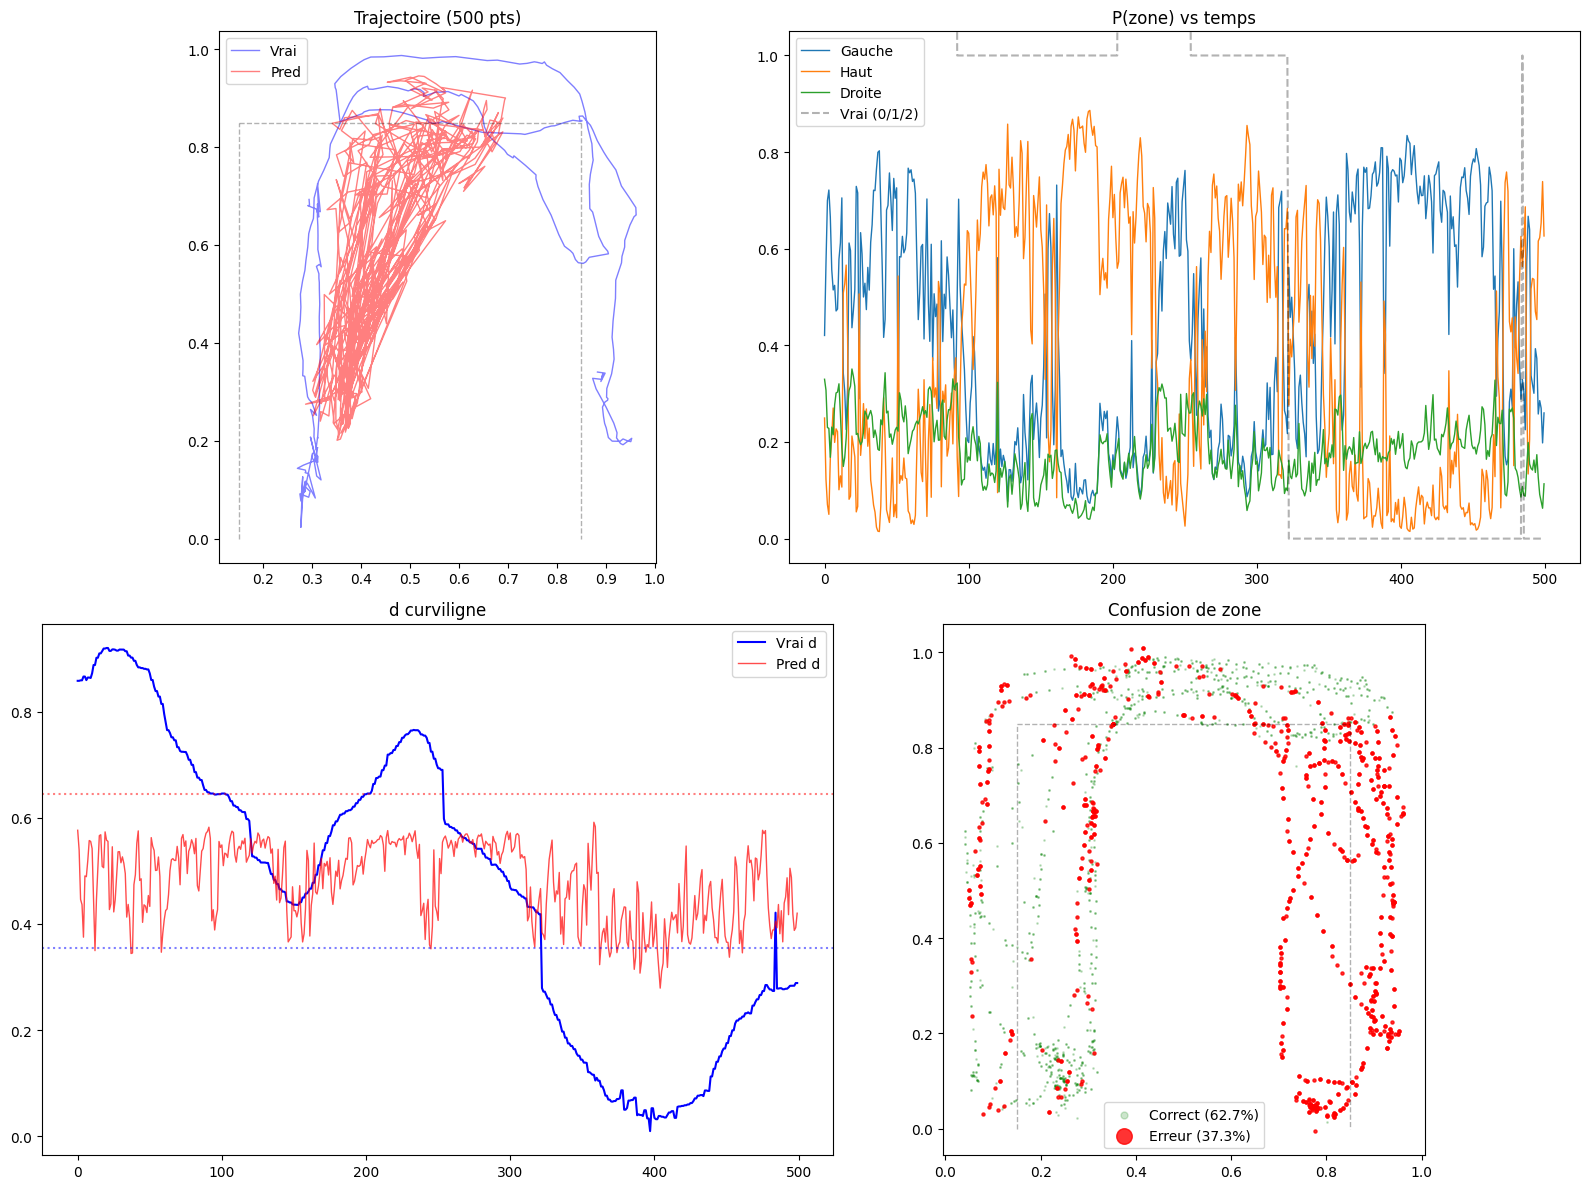

In [26]:
segment = slice(0, 500)
seg_idx = np.arange(500)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Trajectoire 2D
axes[0, 0].plot(y_test[segment, 0], y_test[segment, 1], 'b-', alpha=0.5, label='Vrai', linewidth=1)
axes[0, 0].plot(y_pred[segment, 0], y_pred[segment, 1], 'r-', alpha=0.5, label='Pred', linewidth=1)
for x1, y1, x2, y2 in SKELETON_SEGMENTS:
    axes[0, 0].plot([x1, x2], [y1, y2], 'k--', linewidth=1, alpha=0.3)
axes[0, 0].set_title('Trajectoire (500 pts)'); axes[0, 0].legend(); axes[0, 0].set_aspect('equal')

# 2. Probabilités de zone
for z in range(N_ZONES):
    axes[0, 1].plot(seg_idx, probs_ensemble[segment, z], label=ZONE_NAMES[z], linewidth=1)
axes[0, 1].plot(seg_idx, zone_test_targets[segment], 'k--', alpha=0.3, label='Vrai (0/1/2)')
axes[0, 1].set_title('P(zone) vs temps'); axes[0, 1].legend(); axes[0, 1].set_ylim(-0.05, 1.05)

# 3. Distance curviligne
axes[1, 0].plot(seg_idx, d_test_targets[segment], 'b-', label='Vrai d', linewidth=1.5)
axes[1, 0].plot(seg_idx, d_pred_ensemble[segment], 'r-', alpha=0.7, label='Pred d', linewidth=1)
axes[1, 0].axhline(y=D_LEFT_END, color='blue', linestyle=':', alpha=0.5)
axes[1, 0].axhline(y=D_RIGHT_START, color='red', linestyle=':', alpha=0.5)
axes[1, 0].set_title('d curviligne'); axes[1, 0].legend()

# 4. Carte confusion
correct = ~zone_confusion
axes[1, 1].scatter(y_test[correct, 0], y_test[correct, 1], c='green', s=1, alpha=0.2, label=f'Correct ({correct.mean():.1%})')
if zone_confusion.any():
    axes[1, 1].scatter(y_test[zone_confusion, 0], y_test[zone_confusion, 1], c='red', s=5, alpha=0.8, label=f'Erreur ({zone_confusion_rate:.1%})')
for x1, y1, x2, y2 in SKELETON_SEGMENTS:
    axes[1, 1].plot([x1, x2], [y1, y2], 'k--', linewidth=1, alpha=0.3)
axes[1, 1].set_title('Confusion de zone'); axes[1, 1].legend(markerscale=5); axes[1, 1].set_aspect('equal')

plt.tight_layout(); plt.show()

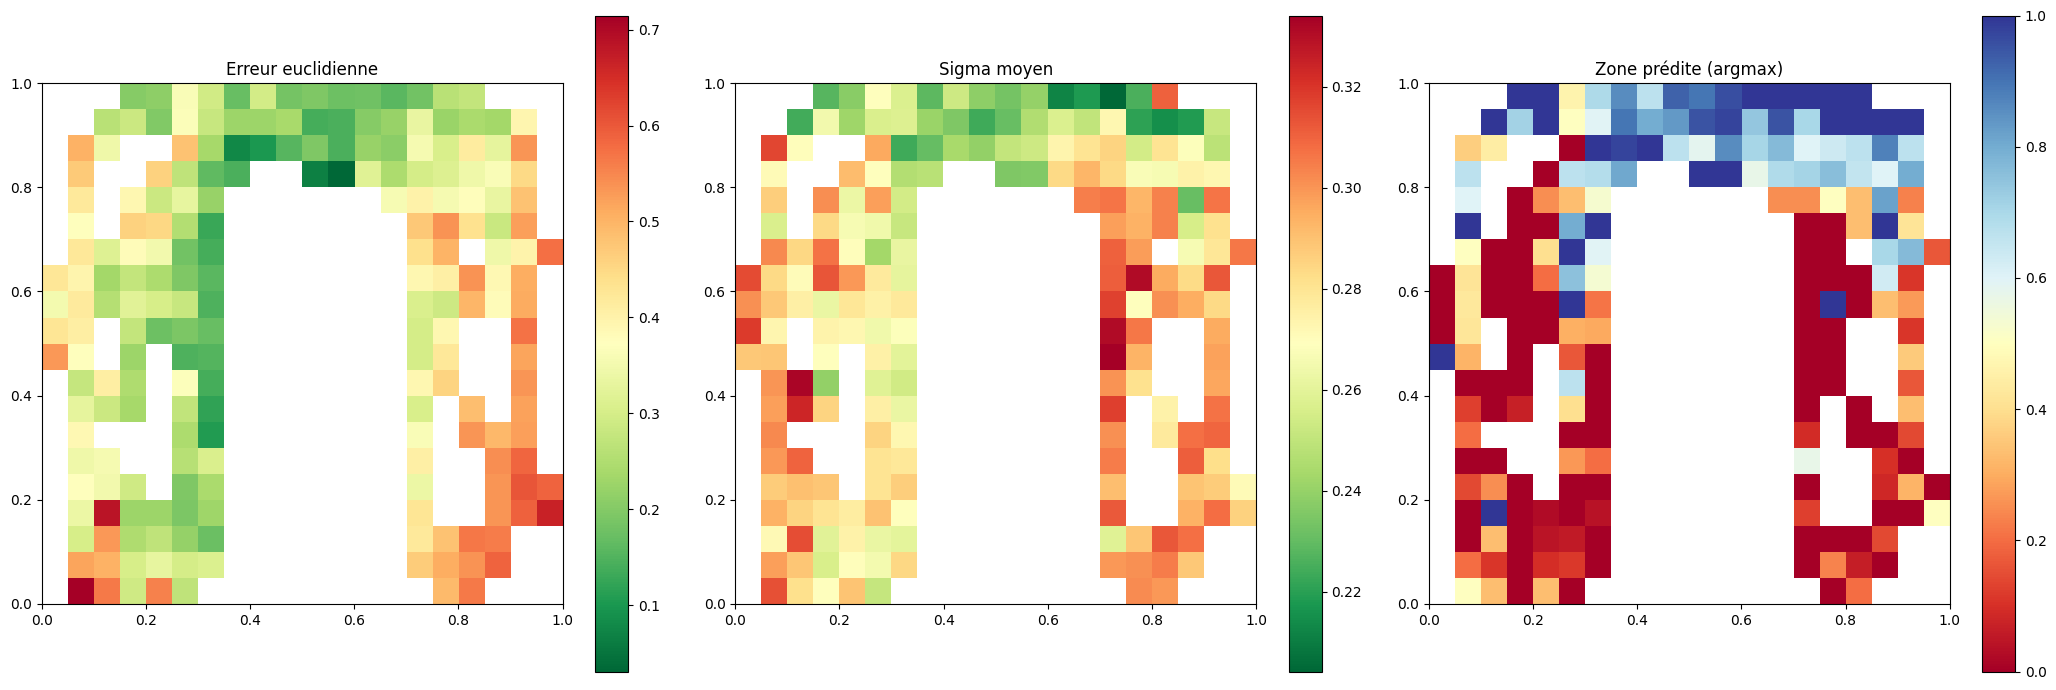

In [27]:
# Heatmaps
fig, axes = plt.subplots(1, 3, figsize=(21, 7))
nbins = 20
x_edges = np.linspace(0, 1, nbins + 1)
y_edges = np.linspace(0, 1, nbins + 1)

for ax_idx, (title, values, cmap) in enumerate([
    ('Erreur euclidienne', eucl_errors, 'RdYlGn_r'),
    ('Sigma moyen', (y_sigma[:, 0] + y_sigma[:, 1]) / 2, 'RdYlGn_r'),
    ('Zone prédite (argmax)', zone_pred.astype(float), 'RdYlBu')
]):
    val_map = np.full((nbins, nbins), np.nan)
    count_map = np.zeros((nbins, nbins))
    for i in range(len(y_test)):
        xi = np.clip(np.searchsorted(x_edges, y_test[i, 0]) - 1, 0, nbins - 1)
        yi = np.clip(np.searchsorted(y_edges, y_test[i, 1]) - 1, 0, nbins - 1)
        if np.isnan(val_map[yi, xi]): val_map[yi, xi] = 0
        val_map[yi, xi] += values[i]; count_map[yi, xi] += 1
    mean_map = np.where(count_map > 0, val_map / count_map, np.nan)
    im = axes[ax_idx].imshow(mean_map, origin='lower', aspect='equal', cmap=cmap, extent=[0, 1, 0, 1])
    axes[ax_idx].set_title(title); plt.colorbar(im, ax=axes[ax_idx])
plt.tight_layout(); plt.show()

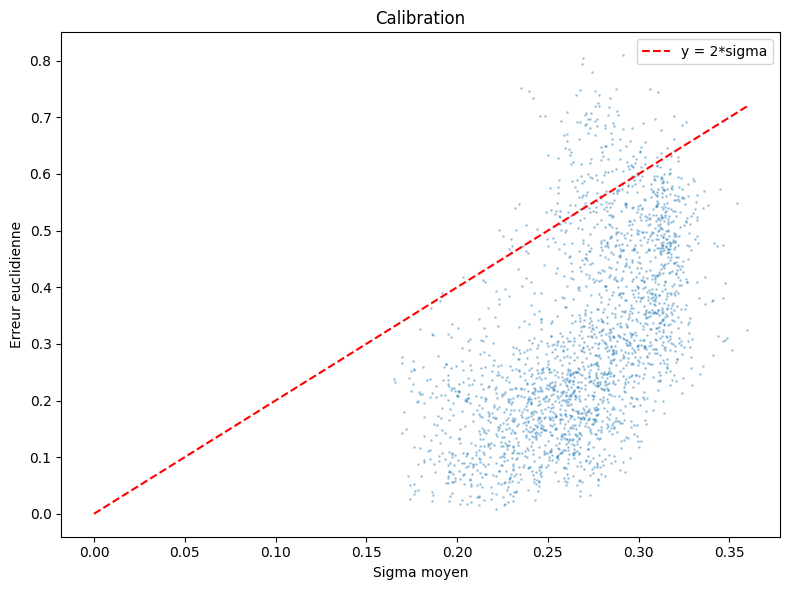

  Erreur < 1*sigma : 48.1% (attendu ~39%)
  Erreur < 2*sigma : 92.6% (attendu ~86%)
  Erreur < 3*sigma : 99.9% (attendu ~99%)


In [28]:
# Calibration
sigma_mean = (y_sigma[:, 0] + y_sigma[:, 1]) / 2
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(sigma_mean, eucl_errors, s=1, alpha=0.3)
sigma_range = np.linspace(0, sigma_mean.max(), 100)
ax.plot(sigma_range, 2 * sigma_range, 'r--', label='y = 2*sigma')
ax.set_xlabel('Sigma moyen'); ax.set_ylabel('Erreur euclidienne')
ax.set_title('Calibration'); ax.legend()
plt.tight_layout(); plt.show()

for k, expected in [(1, '~39%'), (2, '~86%'), (3, '~99%')]:
    pct = np.mean(eucl_errors < k * sigma_mean)
    print(f'  Erreur < {k}*sigma : {pct:.1%} (attendu {expected})')

## 12. Sauvegarde

In [29]:
np.save('../outputs/preds_transformer_02h.npy', y_pred)
np.save('../outputs/sigma_transformer_02h.npy', y_sigma)
np.save('../outputs/d_pred_transformer_02h.npy', d_pred_ensemble)
np.save('../outputs/y_test_transformer_02h.npy', y_test)
np.save('../outputs/d_test_transformer_02h.npy', d_test_targets)
print(f'Sauvegardé : {y_pred.shape}, {y_sigma.shape}, {d_pred_ensemble.shape}')

Sauvegardé : (2298, 2), (2298, 2), (2298,)


## 13. Interprétation

### 3 zones vs 2 bras

Le passage de 2 classes (gauche/droite, seuil d=0.5) à 3 zones (gauche / haut / droite) a plusieurs avantages :

1. **Coins traités séparément** : dans la version 2 classes, les coins du U (jonction bras-couloir) étaient assignés arbitrairement à gauche ou droite. C'est une zone de transition difficile où le signal est ambigu. Avec 3 zones, le couloir haut + coins forment une classe propre.

2. **Meilleure classification** : la tâche est plus facile car chaque zone a une géométrie bien distincte (bras vertical gauche / couloir horizontal / bras vertical droit).

3. **Head spécialisé pour le couloir** : le head du couloir haut peut apprendre que y ≈ 0.85 et x varie de 0.15 à 0.85, sans être perturbé par les bras verticaux.

### Seuils naturels

Les seuils d=0.354 et d=0.646 ne sont pas arbitraires : ils correspondent exactement aux jonctions entre les segments du squelette du U. C'est la frontière géométrique naturelle entre les zones.

### Mélange 3 composantes

La prédiction finale est un mélange de 3 gaussiennes pondérées par softmax. Par rapport au mélange 2 composantes :
- Dans les bras purs, une seule composante domine (p ≈ 1)
- Dans le couloir, la composante "haut" domine
- Aux transitions, l'incertitude augmente naturellement via la variance du mélange